In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
with ZipFile('/content/drive/Shareddrives/Darwin Project Datasets II/IDRiD_augmented/augmented_dataset512x512.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall('/tmp')

In [ ]:
import os

# Obtener el directorio actual
directorio_actual = '/tmp/augmented_data/'
print("Directorio actual:", directorio_actual)

# Obtener la lista de archivos en el directorio actual
archivos = os.listdir(directorio_actual)
print("Archivos en el directorio actual:")
for archivo in archivos:
    print(archivo)

Directorio actual: /tmp/augmented_data/
Archivos en el directorio actual:
microaneurysms_mask
dataset.csv
haemorrhages_mask
optic_disk_mask
hard_exudates_mask
images


In [ ]:
import shutil

# Ruta completa del directorio que deseas eliminar
ruta_directorio = '/tmp/augmented_data/masks/.ipynb_checkpoints'
# Verificar si el directorio existe antes de eliminarlo
if os.path.exists(ruta_directorio):
    # Eliminar el directorio y su contenido
    shutil.rmtree(ruta_directorio)
    print(f"El directorio {ruta_directorio} ha sido eliminado.")
else:
    print(f"El directorio {ruta_directorio} no existe.")

NameError: ignored

In [ ]:
def unet_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Decoder
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output
    outputs = Conv2D(num_classes, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

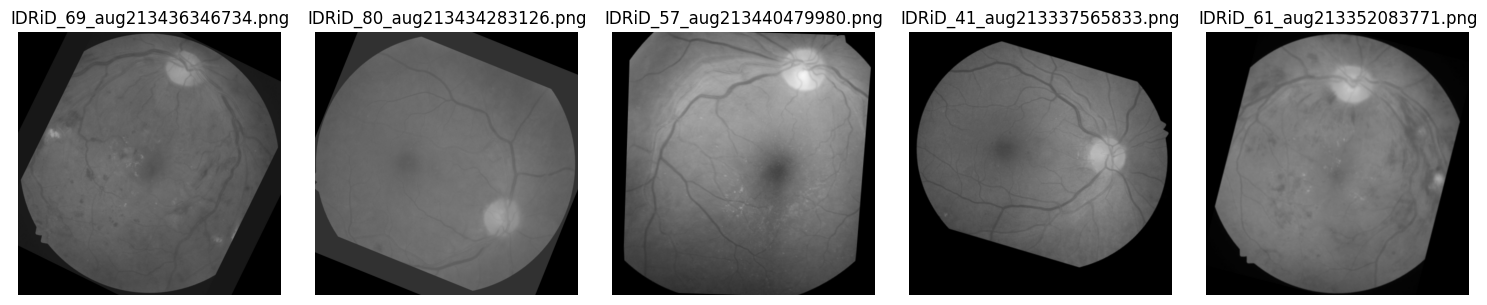

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt


# Directorio de imágenes
directorio_imagenes = '/tmp/augmented_data/images'
clases = os.listdir(directorio_imagenes)

# Obtener una lista de nombres de archivo aleatorios
archivos_aleatorios = random.sample(os.listdir(directorio_imagenes), 5)

# Crear una figura con subtramas
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Graficar las imágenes y los nombres
for i, archivo in enumerate(archivos_aleatorios):
    ruta_imagen = os.path.join(directorio_imagenes, archivo)
    imagen = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    axs[i].imshow(imagen)
    axs[i].axis('off')
    axs[i].set_title(archivo)

plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy



In [ ]:
# Directorio de datos
data_dir = '/tmp/augmented_data'

# Tamaño de las imágenes y número de clases
input_shape = (256, 256, 1)  # 256x256 imágenes RGB
num_classes = 1  # número correcto de clases (en este caso, 4 tipos de máscaras)

# Obtener rutas de imágenes y máscaras
#image_dir = os.path.join(data_dir, 'images')
#mask_dir = os.path.join(data_dir, 'masks')

image_dir = '/tmp/augmented_data/images'
mask_dir = '/tmp/augmented_data/optic_disk_mask'

# Obtener la lista de nombres de archivos de imágenes
image_filenames = os.listdir(image_dir)

In [ ]:
unique_classes = np.unique(masks)
print(unique_classes)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76]


In [ ]:
import tensorflow as tf
from keras import layers

def up_conv_block(inputs, filters):
    upsample = layers.UpSampling2D(size=(2, 2))(inputs)
    conv = layers.Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(upsample)
    return conv


def conv_block(inputs, filters):
    conv1 = layers.Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    conv2 = layers.Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(conv1)
    return conv2

def cbam_block(inputs, ratio=8):
    channels = inputs.shape[-1]

    # Atención espacial (Spatial Attention)
    spatial_max = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
    spatial_avg = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
    spatial_concat = layers.Concatenate()([spatial_max, spatial_avg])
    spatial_dense1 = layers.Dense(channels // ratio, activation='relu')(spatial_concat)
    spatial_dense2 = layers.Dense(channels, activation='sigmoid')(spatial_dense1)
    spatial_attention = layers.Multiply()([inputs, spatial_dense2])

    # Atención de canales (Channel Attention)
    channel_max = tf.reduce_max(inputs, axis=3, keepdims=True)
    channel_avg = tf.reduce_mean(inputs, axis=3, keepdims=True)
    channel_concat = layers.Concatenate(axis=3)([channel_max, channel_avg])
    channel_dense1 = layers.Conv2D(channels // ratio, kernel_size=(1, 1), activation='relu')(channel_concat)
    channel_dense2 = layers.Conv2D(channels, kernel_size=(1, 1), activation='sigmoid')(channel_dense1)
    channel_attention = layers.Multiply()([inputs, channel_dense2])

    return layers.Add()([spatial_attention, channel_attention])

def unet_with_cbam(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 128)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 256)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, 512)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Middle
    conv5 = conv_block(pool4, 1024)

    # Decoder
    up6 = up_conv_block(conv5, 512)
    concat6 = layers.Concatenate()([up6, conv4])
    conv6 = conv_block(concat6, 512)

    up7 = up_conv_block(conv6, 256)
    concat7 = layers.Concatenate()([up7, conv3])
    conv7 = conv_block(concat7, 256)

    up8 = up_conv_block(conv7, 128)
    concat8 = layers.Concatenate()([up8, conv2])
    conv8 = conv_block(concat8, 128)

    up9 = up_conv_block(conv8, 64)
    concat9 = layers.Concatenate()([up9, conv1])
    conv9 = conv_block(concat9, 64)

    # CBAM
    cbam = cbam_block(conv9, ratio=8)  # Ajustar el valor del ratio según sea necesario

    outputs = layers.Conv2D(num_classes, kernel_size=(1, 1), activation='softmax')(cbam)

    model = Model(inputs=inputs, outputs=outputs)
    return model



In [ ]:
import tensorflow as tf
from keras import backend as K

def mean_iou(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred = K.one_hot(y_pred, num_classes)
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes)

    intersect = K.sum(y_true[..., 1:] * y_pred[..., 1:], axis=[1, 2])
    union = K.sum(K.maximum(y_true[..., 1:], y_pred[..., 1:]), axis=[1, 2])

    smooth = 1.0
    iou = (intersect + smooth) / (union + smooth)

    return K.mean(iou)

def mean_iou_thresholded(threshold=0.5):
    def metric(y_true, y_pred):
        y_pred = K.argmax(y_pred, axis=-1)
        y_pred = K.one_hot(y_pred, num_classes)
        y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes)

        intersect = K.sum(y_true[..., 1:] * y_pred[..., 1:], axis=[1, 2])
        union = K.sum(K.maximum(y_true[..., 1:], y_pred[..., 1:]), axis=[1, 2])

        smooth = 1.0
        iou = (intersect + smooth) / (union + smooth)

        return K.mean(K.greater(iou, threshold))

    return metric

In [ ]:
from keras.utils import to_categorical
#from utils import conv_block

# Cargar imágenes y máscaras
def load_images_and_masks(image_filenames, mask_dir, input_shape):
    images = []
    masks = []
    for image_filename in image_filenames:
        image_path = os.path.join(image_dir, image_filename)

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (input_shape[1], input_shape[0]))
        image = image.astype(np.float32) / 255.0  # Normalizar entre 0 y 1

        # Agregar una dimensión para el número de canales
        image = np.expand_dims(image, axis=-1)
        images.append(image)

        # Leer la máscara con el mismo nombre que la imagen
        mask_filename = image_filename  # El nombre de la máscara es el mismo que el de la imagen
        mask_path = os.path.join(mask_dir, mask_filename)  # Ruta de la máscara correspondiente a la imagen
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Leemos la máscara en escala de grises
        mask = cv2.resize(mask, (input_shape[1], input_shape[0]))
        mask = np.expand_dims(mask, axis=-1)  # Agregar una dimensión para la clase
        masks.append(mask)

    masks = np.array(masks)  # Convertir la lista a un arreglo numpy
    return np.array(images), masks

# Cargar imágenes y máscaras
images, masks = load_images_and_masks(image_filenames, mask_dir, input_shape)
print(images[0].shape)
print(masks[0].shape)

# Crear el modelo U-Net
model = unet_with_cbam(input_shape, num_classes)

# Compilar el modelo con las nuevas métricas
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',  # Utilizar esta pérdida para máscaras con valores enteros
              metrics=[mean_iou, mean_iou_thresholded()])

# Guardar el mejor modelo durante el entrenamiento
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# Dividir datos en entrenamiento y validación
split_idx = int(len(images) * 0.8)  # 80% de los datos para entrenamiento, 20% para validación

train_images, val_images = images[:split_idx], images[split_idx:]
train_masks, val_masks = masks[:split_idx], masks[split_idx:]

# Entrenar el modelo
history = model.fit(train_images, train_masks,
                    epochs=30,  # Número de épocas (ajustar según sea necesario)
                    batch_size=16,  # Tamaño del lote (ajustar según sea necesario)
                    validation_data=(val_images, val_masks),
                    callbacks=[checkpoint])

(256, 256, 1)
(256, 256, 1)
Epoch 1/30


ValueError: ignored

In [ ]:
!pip install utils

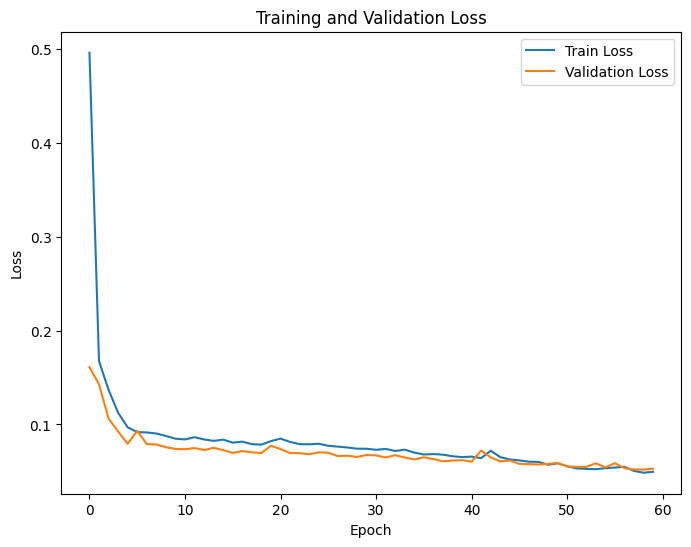

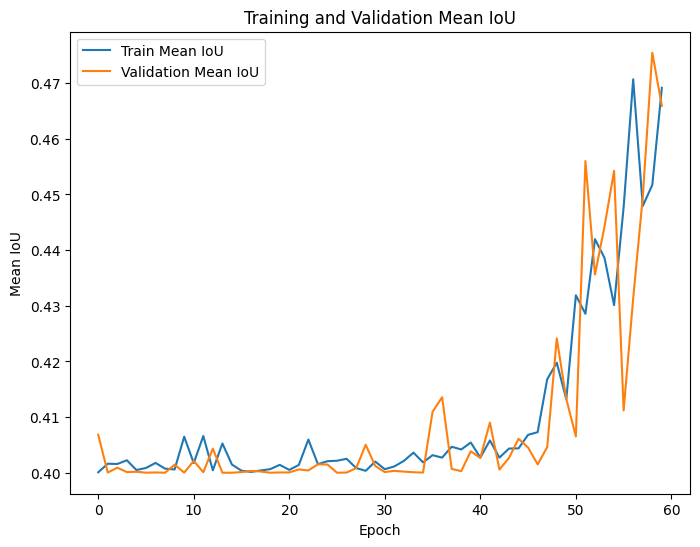

In [ ]:
import matplotlib.pyplot as plt
# Obtener las métricas de entrenamiento y validación del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mean_iou = history.history['mean_io_u']
val_mean_iou = history.history['val_mean_io_u']

# Crear gráfico de pérdida
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Crear gráfico de precisión (Mean IoU)
plt.figure(figsize=(8, 6))
plt.plot(train_mean_iou, label='Train Mean IoU')
plt.plot(val_mean_iou, label='Validation Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.title('Training and Validation Mean IoU')
plt.legend()
plt.show()

In [ ]:
# Guardar el modelo en un archivo
model.save('/content/drive/Shareddrives/Darwin Project Datasets II/Modelos/modelo_entrenado_idrid_1.h5')


ValueError: ignored

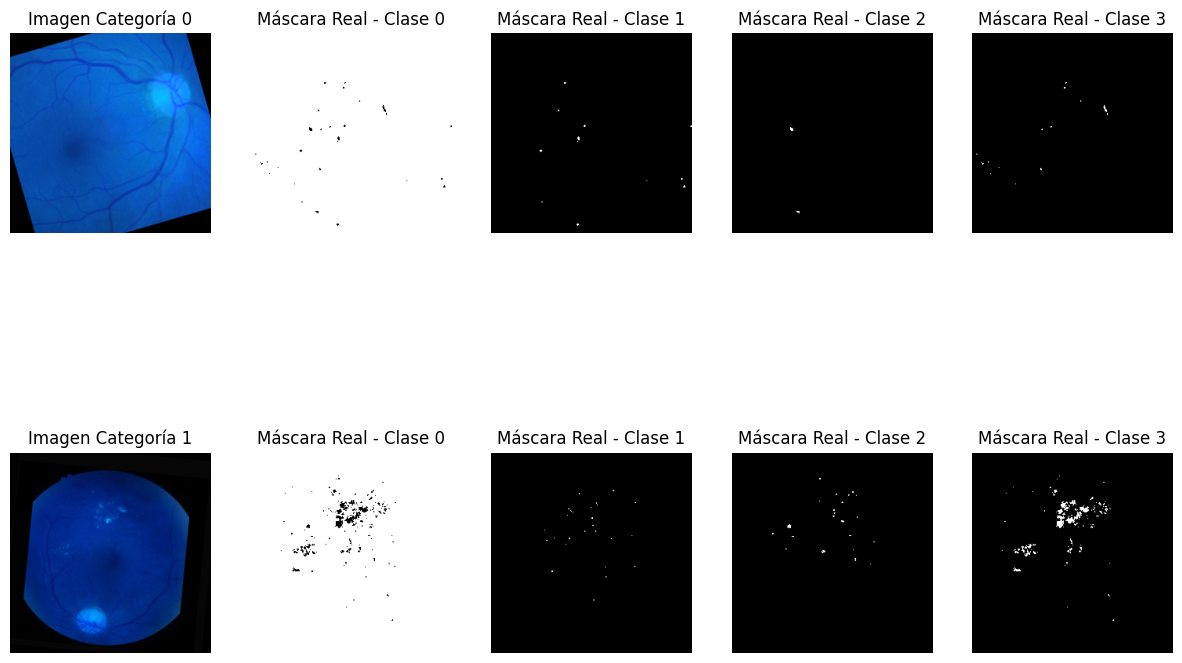

In [ ]:
import random
import matplotlib.pyplot as plt

# Función para obtener un índice aleatorio para cada categoría
def get_random_index_per_category(masks):
    num_classes = masks.shape[-1]
    random_indexes = [random.randint(0, masks.shape[0] - 1) for _ in range(num_classes)]
    return random_indexes

# Obtener índices aleatorios para cada categoría
random_indexes = get_random_index_per_category(val_masks_one_hot)

plt.figure(figsize=(15, 10))

# Visualizar la imagen original y las máscaras reales para cada categoría
for i, random_index in enumerate(random_indexes):
    image = val_images[random_index]
    masks_real = val_masks_one_hot[random_index]

    plt.subplot(2, num_classes + 1, i * (num_classes + 1) + 1)
    plt.imshow(image)
    plt.title(f"Imagen Categoría {i}")
    plt.axis("off")

    for j in range(num_classes):
        plt.subplot(2, num_classes + 1, i * (num_classes + 1) + j + 2)
        plt.imshow(masks_real[:, :, j], cmap='gray')
        plt.title(f"Máscara Real - Clase {j}")
        plt.axis("off")

# Visualizar la imagen original y las máscaras de predicción para cada categoría
for i, random_index in enumerate(random_indexes):
    image = val_images[random_index]

    # Realizar la predicción en la imagen utilizando el modelo entrenado
    masks_pred = model.predict(image[np.newaxis, ...])[0]

    plt.subplot(2, num_classes + 1, (i + 1) * (num_classes + 1) + 1)
    plt.imshow(image)
    plt.title(f"Imagen Categoría {i}")
    plt.axis("off")

    for j in range(num_classes):
        plt.subplot(2, num_classes + 1, (i + 1) * (num_classes + 1) + j + 2)
        plt.imshow(masks_pred[:, :, j], cmap='gray')
        plt.title(f"Máscara Predicción - Clase {j}")
        plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
print(train_images.shape)
print(train_masks.shape)
print(val_images.shape)
print(val_masks.shape)

(640, 256, 256, 3)
(640, 256, 256, 4)
(160, 256, 256, 3)
(160, 256, 256, 4)
